### Resources

- https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf
- https://arxiv.org/pdf/1312.5602
- https://www.lesswrong.com/posts/kyvCNgx9oAwJCuevo/deep-q-networks-explained

In [1]:
# colab requirements
!pip install stable_baselines3
!pip install ale_py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import torch
import torch.nn as nn
import gymnasium as gym
import ale_py
import pickle
import matplotlib.pyplot as plt

from collections import deque
from gymnasium.wrappers import FrameStack
from stable_baselines3.common.atari_wrappers import (
    AtariWrapper,
    FireResetEnv,
    EpisodicLifeEnv,
    MaxAndSkipEnv,
)

gym.register_envs(ale_py)

Helper functions

In [3]:
def display_frame(frame, gray=False):
    if gray:
        plt.imshow(frame, cmap='gray')
    else:
        plt.imshow(frame)
    plt.axis('off')
    plt.show()

In [4]:
def display_multiple_frames(frames):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(frames[i], cmap='gray')
        ax.axis('off')
    plt.show()

In [5]:
def make_env(game):
    env = gym.make(game, render_mode='rgb_array')
    env = AtariWrapper(env)
    env = FrameStack(env, num_stack=4)
    env = MaxAndSkipEnv(env, skip=4)
    env = EpisodicLifeEnv(env)
    env = FireResetEnv(env)
    return env

In [6]:
env = make_env('PongNoFrameskip-v4')

Before processing state

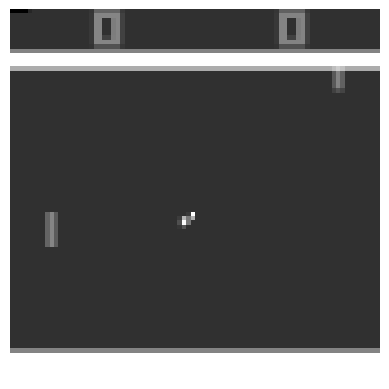

In [7]:
obs, info = env.reset()
display_frame(obs[-1], gray=True)

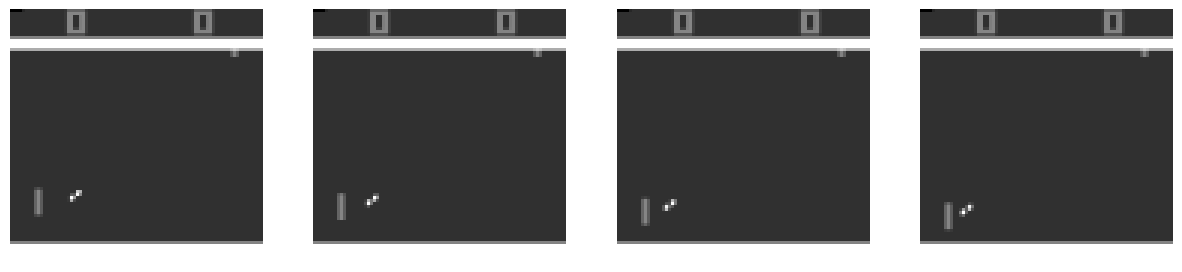

In [8]:
obs, info = env.reset()
display_multiple_frames(obs)

### Experience Replay

In [10]:
class ReplayBuffer:

    def __init__(self, capacity=50000) -> None:
        self._buffer_obs = deque(maxlen=capacity)
        self._buffer_acts = deque(maxlen=capacity)
        self._buffer_rs = deque(maxlen=capacity)
        self._buffer_obs_ps = deque(maxlen=capacity)
        self._buffer_dones = deque(maxlen=capacity)

        self._buffers = [self._buffer_obs, self._buffer_acts, self._buffer_rs, self._buffer_obs_ps, self._buffer_dones]

    def store(self, experience: tuple) -> None:
        for i, thing in enumerate(experience):
            self._buffers[i].append(thing)

    def sample(self, batch_size):
        indices = np.random.randint(0, high=len(self), size=(batch_size))

        observations, actions, rewards, obs_primes, dones = self.buffers
        return (
            np.take(observations, indices, axis=0),
            np.take(actions, indices, axis=0).reshape(-1, 1),
            np.take(rewards, indices, axis=0).reshape(-1, 1),
            np.take(obs_primes, indices, axis=0),
            np.take(dones, indices, axis=0).reshape(-1, 1),
        )

    def __len__(self):
        return len(self._buffer_obs)

    def __getitem__(self, index):
        return tuple([buffer[index] for buffer in self._buffers])

    def __setitem__(self, index, value: tuple):
        for i, buffer in enumerate(self._buffers):
            buffer[index] = value[i]

    def shuffle(self):
        np.random.shuffle(self.buffer)

    @property
    def shape(self):
        if len(self._buffer_obs) > 0:
            shape = (len(self._buffer_obs), 5)
            return shape
        else:
            return (0,)

    @property
    def buffers(self):
      npbuffers = [np.array(buffer) for buffer in self._buffers]
      return tuple(npbuffers)

In [14]:
NUM_EPS = 200
buffer_pong = ReplayBuffer()

for episode in range(NUM_EPS):
    done = False
    observation, _ = env.reset()
    step = 1

    next_state = [observation]

    while not done:
        action = env.action_space.sample()

        observation_prime, reward, terminated, truncated, _ = env.step(action)
        buffer_pong.store((observation[:, :, :, 0], action, reward, observation_prime[:, :, :, 0], terminated or truncated))
        observation = observation_prime

        done = terminated or truncated

print(len(buffer_pong))

43480


(4, 84, 84)


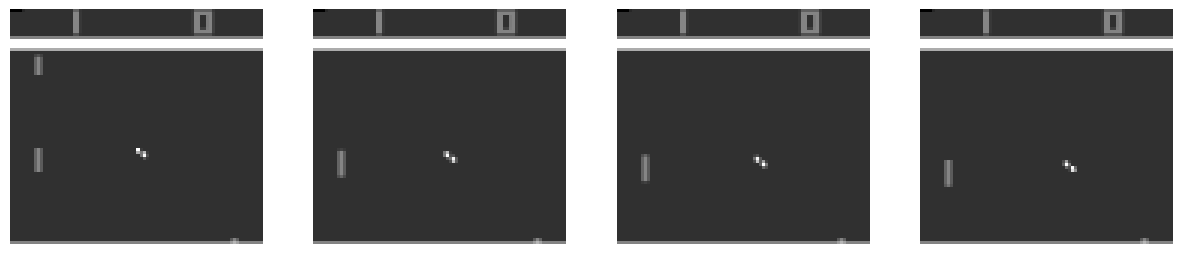

In [12]:
frame = buffer_pong[10][3]
print(frame.shape)
display_multiple_frames(frame)

In [ ]:
with open('replays/replay1.pkl', 'wb') as f:
    pickle.dump(buffer_pong, f)

In [28]:
class DQN(nn.Module):

    def __init__(
        self,
        env,
        in_channels = 4,
        num_actions = 6,
        hidden_filters = [16, 32],
        start_epsilon = 0.99,
        max_decay = 0.1,
        decay_steps = 1000,
        *args,
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.start_epsilon = start_epsilon
        self.epsilon = start_epsilon
        self.max_decay = max_decay
        self.decay_steps = decay_steps
        self.env = env

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, hidden_filters[0], kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(hidden_filters[0], hidden_filters[1], kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(hidden_filters[1] * 9 * 9, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

        self.apply(self._init)

    def _init(self, m):
      if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
          nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.layers(x / 255.0)

    def epsilon_greedy(self, state, dim=1):
        q_values = self(state)
        rng = np.random.random()

        if rng < self.epsilon:
            action = self.env.action_space.sample()
            action = torch.tensor(action)
        else:
            action = torch.argmax(q_values, dim=dim)

        return action

    def epsilon_decay(self, step):
        self.epsilon = self.max_decay + (self.start_epsilon - self.max_decay) * max(0, (self.decay_steps - step) / self.decay_steps)


In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Training procedure

In [40]:
TIMESTEPS = 1000000
LR = 2.5e-4
BATCH_SIZE = 32
C = 1000
GAMMA = 0.99
STATS = 50000

q_network = DQN(env, decay_steps=TIMESTEPS).to(device)
target_network = DQN(env, decay_steps=TIMESTEPS).to(device)
target_network.load_state_dict(q_network.state_dict())

loss_func = nn.MSELoss()
optimizer = torch.optim.AdamW(q_network.parameters(), lr=LR)

losses = []
rewards_list = []

for step in range(1, TIMESTEPS):

    obs, _ = env.reset()
    episode += 1
    total_reward = 0
    total_loss = 0

    batched_obs = obs[np.newaxis, :, :, :, 0]
    action = q_network.epsilon_greedy(torch.tensor(batched_obs).float().to(device)).cpu().item()
    obs_prime, reward, terminated, trunctated, _ = env.step(action)

    buffer_pong.store((obs[:, :, :, 0], action, reward, obs_prime[:, :, :, 0], terminated or truncated))
    total_reward += reward
    if terminated or truncated:
        rewards_list.append(total_reward)
        total_reward = 0

    observations, actions, rewards, observation_primes, dones = buffer_pong.sample(BATCH_SIZE)
    with torch.no_grad():
        q_values_minus = target_network(torch.tensor(observation_primes).float().to(device))
        boostrapped_values = torch.amax(q_values_minus, dim=1, keepdim=True)

    terminated_primes = torch.tensor(dones).bool().to(device)
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    rewards = torch.tensor(rewards).float().to(device)
    y_trues = torch.empty((BATCH_SIZE, 1)).to(device)

    y_trues = torch.where(terminated_primes, rewards, rewards + GAMMA * boostrapped_values)
    y_preds = q_network(torch.tensor(observations).float().to(device))

    loss = loss_func(y_preds.gather(1, actions), y_trues)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    q_network.epsilon_decay(step)
    target_network.epsilon_decay(step)

    done = terminated or truncated
    obs = obs_prime
    if step % C == 0:
        target_network.load_state_dict(q_network.state_dict())

    losses.append(loss)
    print(f'Episode: {step}, Loss: {loss:.4f}, Epsilon: {q_network.epsilon:.4f}, Reward: {rewards_list[-1] if len(rewards_list) > 0 else 0.0}',
          end='\r',
          flush=True
    )

env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyboardInterrupt: 

In [123]:
torch.save(q_network.state_dict(), 'q_net1.pt')

In [ ]:
env_test = make_env('PongNoFrameskip-v4', render='human')

q_network_trained = DQN(env_test)
q_network_trained.load_state_dict(torch.load('q_net1.pt', weights_only=True))
q_network_trained.eval()

In [ ]:
done = False
total_reward = 0

obs, _ = env_test.reset()
while not done:
    batched_obs = obs[np.newaxis, :, :, :, 0]
    with torch.no_grad():
        logits = q_network_trained(torch.tensor(batched_obs).float())
        action = torch.argmax(logits, dim=1).item()

    next_observation, reward, terminated, truncated, _ = env_test.step(action)
    total_reward += reward
    obs = next_observation

    done = terminated or truncated

env_test.close()
print(f'Total reward achieved: {total_reward}')